In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa

In [3]:
keylist = np.load("data/traces_0/Tutorial_HW_CW305_data/traces/2025.01.07-17.13.21_0keylist.npy", allow_pickle=True)
knownkey = np.load("data/traces_0/Tutorial_HW_CW305_data/traces/2025.01.07-17.13.21_0knownkey.npy", allow_pickle=True)
textin = np.load("data/traces_0/Tutorial_HW_CW305_data/traces/2025.01.07-17.13.21_0textin.npy", allow_pickle=True)
textout = np.load("data/traces_0/Tutorial_HW_CW305_data/traces/2025.01.07-17.13.21_0textout.npy", allow_pickle=True)
traces = np.load("data/traces_0/Tutorial_HW_CW305_data/traces/2025.01.07-17.13.21_0traces.npy", allow_pickle=True)
print(f"Traces {traces.shape}")
print(f"textin {textin.shape}")
print(f"textout {textout.shape}")
print(f"knownkey {keylist.shape}")
print(f"First plaintext is {textin[0]}")

Traces (5001, 129)
textin (5000, 16)
textout (5000, 16)
knownkey (5000, 16)
First plaintext is [136  17 232 118 167  80 215  42  90 211 155 243 111 118 171  78]


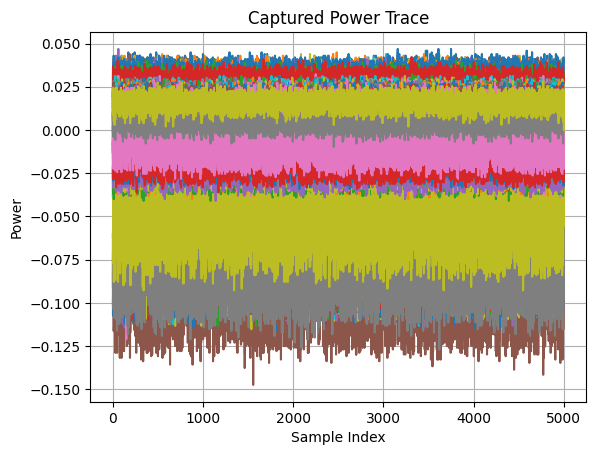

In [20]:
# Example: plot the waveform
waveform = traces
plt.plot(waveform)
plt.title("Captured Power Trace")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.grid(True)
plt.show()

In [21]:
SAMPLE_RATE_HZ = 29_500_000  # based on extclk_x4 * 7.37 MHz
time_axis = np.arange(waveform.shape[1]) / SAMPLE_RATE_HZ * 1e6  # time in µs

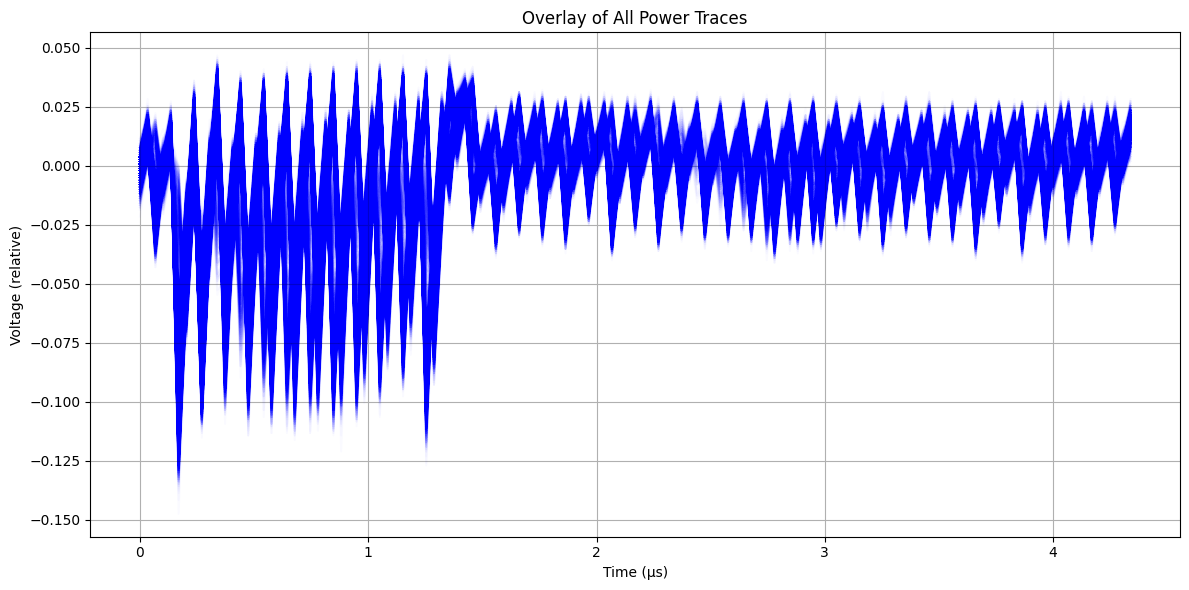

In [22]:
# === Plot all traces ===
plt.figure(figsize=(12, 6))
for trace in waveform:
    plt.plot(time_axis, trace, color='blue', alpha=0.02)  # alpha for transparency

plt.title("Overlay of All Power Traces")
plt.xlabel("Time (µs)")
plt.ylabel("Voltage (relative)")
plt.grid(True)
plt.tight_layout()
plt.show()

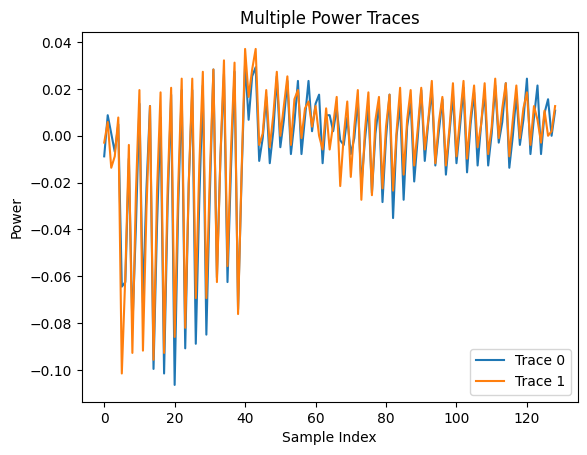

In [23]:
# multiple traces
for i in range(2):  # Plot first 2 traces
    plt.plot(traces[i], label=f"Trace {i}")
plt.legend()
plt.title("Multiple Power Traces")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.show()

In [ ]:

project_file = "data/traces_0/Tutorial_HW_CW305"
project = cw.open_project(project_file)
attack = cwa.cpa(project, cwa.leakage_models.last_round_state_diff)
cb = cwa.get_jupyter_callback(attack)

In [26]:
attack_results = attack.run(cb)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,D00.077,140.094,F90.093,A80.084,C90.081,EE0.074,250.067,890.083,E10.080,3F0.063,0C0.077,C80.084,B60.068,630.072,0C0.079,A60.081
1,370.056,200.050,6D0.055,630.054,660.064,690.057,600.058,C80.053,4E0.052,B10.051,D60.055,470.052,0D0.066,1F0.054,BE0.061,920.052
2,1B0.053,1D0.048,A60.050,FB0.051,620.064,540.053,B20.056,4C0.051,6F0.048,3C0.049,340.054,000.051,D10.055,620.053,B40.060,830.050
3,FA0.052,FF0.048,CF0.048,E30.050,ED0.055,3D0.051,3B0.056,720.051,710.045,7A0.049,080.053,F90.047,E80.050,A30.050,B20.053,120.045
4,7C0.051,300.048,DE0.046,AE0.048,0F0.052,8C0.049,CA0.050,CD0.048,B70.044,2A0.048,980.051,0B0.047,660.050,880.049,E30.052,290.044


In [27]:
import pickle
pickle_file = project_file + ".results.pickle"
pickle.dump(attack_results, open(pickle_file, "wb"))

In [28]:
from chipwhisperer.analyzer.attacks.models.aes.key_schedule import key_schedule_rounds
recv_lastroundkey = [kguess[0][0] for kguess in attack_results.find_maximums()]
recv_key = key_schedule_rounds(recv_lastroundkey, 10, 0)
for subkey in recv_key:
    print(hex(subkey))

0x2b
0x7e
0x15
0x16
0x28
0xae
0xd2
0xa6
0xab
0xf7
0x15
0x88
0x9
0xcf
0x4f
0x3c


In [33]:
key = list(keylist[0])
assert (key == recv_key), "Failed to recover encryption key\nGot:      {}\nExpected: {}".format(recv_key, key)

In [39]:
true_key = ''.join(f'{byte:02x}' for byte in key)
print(true_key)

2b7e151628aed2a6abf7158809cf4f3c


## Using the ChipWhisperer Analyzer Module on Our Traces

In [ ]:
data = np.load("data/traces_1.npz", allow_pickle=True)
plaintexts = data['dut_io_data']
ciphertexts = data['dut_io_computed_data']
traces = data['wave']


# Create a dummy key of the same length
key_placeholder = bytearray(16)

# Set leakage model:
leak_model = cwa.leakage_models.last_round_state_diff

# Create the CW project and append traces
# Make sure the 'data/traces_1' directory exists
import os
if not os.path.exists("data/traces_1"):
    os.makedirs("data/traces_1")
    
proj = cw.create_project("data/traces_1/CW_305.cwp", overwrite=True)

print("Processing and appending traces to the project...")
for i, (wave, pt_raw, ct_raw) in enumerate(zip(traces, plaintexts, ciphertexts)):
    pt = pt_raw
    ct = ct_raw
    
    # Sanity check: ensure all blocks have the correct fixed length
    assert len(pt) == 16 and len(ct) == 16, \
           f"Trace {i}: Got pt/ct lengths {len(pt)}/{len(ct)}, expected {16}"
           
    proj.traces.append(cw.Trace(wave, pt, ct, key_placeholder))

print(f"Successfully processed {len(proj.traces)} traces.")
proj.save()  # save the project for later use


Processing and appending traces to the project...
Successfully processed 2000 traces.


In [13]:
# Instantiate and run CPA
print("Instantiating and running CPA attack...")
attack = cwa.cpa(proj, leak_model)
cb = cwa.get_jupyter_callback(attack)
best_guesses = attack.run(cb)

print("\n--- Attack Results ---")
print("Recovered key-byte guesses:", best_guesses)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,177,117,87,2,52,217,8,116,19,93,135,218,48,94,88,172
0,D50.175,5E0.169,840.189,A70.209,430.202,250.201,200.170,BC0.138,C00.135,240.212,830.198,880.181,1D0.188,150.156,880.169,000.151
1,E80.088,EC0.100,1B0.091,840.089,8A0.099,CB0.096,680.090,E00.095,970.097,460.101,3B0.092,600.090,290.089,730.102,3F0.094,180.107
2,4A0.086,240.099,460.088,CB0.081,BD0.089,530.093,710.085,FE0.091,AC0.090,F70.090,760.089,CE0.089,E00.087,E20.098,5E0.086,B00.101
3,0B0.084,F90.090,7B0.087,5E0.081,5A0.086,F60.089,430.083,E70.083,EA0.081,550.087,670.086,2D0.086,EF0.087,1C0.096,C80.084,F30.093
4,0C0.084,1D0.087,760.082,2A0.081,010.084,520.089,AA0.081,3D0.082,9B0.081,DD0.086,EA0.086,320.086,0B0.083,A40.094,670.083,0C0.088



--- Attack Results ---
Recovered key-byte guesses: Subkey KGuess Correlation
  00    0xD5    0.17502
  01    0x5E    0.16914
  02    0x84    0.18881
  03    0xA7    0.20878
  04    0x43    0.20177
  05    0x25    0.20134
  06    0x20    0.17032
  07    0xBC    0.13765
  08    0xC0    0.13475
  09    0x24    0.21179
  10    0x83    0.19846
  11    0x88    0.18064
  12    0x1D    0.18807
  13    0x15    0.15575
  14    0x88    0.16866
  15    0x00    0.15085



In [17]:
from chipwhisperer.analyzer.attacks.models.aes.key_schedule import key_schedule_rounds
recv_lastroundkey = [kguess[0][0] for kguess in best_guesses.find_maximums()]
recv_key = key_schedule_rounds(recv_lastroundkey, 10, 0)
for subkey in recv_key:
    print(hex(subkey), end="")

0x100xa50x880x690xd70x4b0xe50xa30x740xcf0x860x7c0xfb0x470x380x59